<a href="https://www.kaggle.com/code/saptaksen/mental-health-analysis-and-support?scriptVersionId=232490468" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Mental Health Text Analysis and Support System
## Capstone Project for Google Gen AI Intensive Course

**Author:** Saptak

## Overview

This notebook demonstrates the application of generative AI to address mental health support systems. Mental health is a critical global health priority, but access to quality support remains challenging for many. This project showcases how generative AI can assist in analyzing text data to identify mental health concerns and provide appropriate support responses.

### Gen AI Capabilities Demonstrated:
1. **Retrieval Augmented Generation (RAG)** - To provide evidence-based mental health information
2. **Few-shot prompting** - To improve specialized mental health response generation
3. **Structured output/JSON mode** - To categorize and analyze mental health text data
4. **Long context window** - To maintain conversation history for coherent support conversations
5. **Document understanding** - To analyze and extract insights from mental health literature
6. **Agentic Workflows with LangGraph** - To orchestrate analysis, retrieval, and response generation in a structured manner.

### Problem Statement:
Mental health support systems face several challenges:
- Limited availability of mental health professionals
- Delays in identifying concerning patterns in communication
- Need for consistent, evidence-based responses
- Privacy and personalization requirements

This project creates an AI-assisted system that can:
1. Analyze text data to identify potential mental health concerns
2. Categorize the type and severity of concerns
3. Generate appropriate, empathetic responses
4. Provide evidence-based information from reliable sources
5. Maintain contextual awareness for ongoing supportive conversations
6. Execute a defined workflow for handling user input using LangGraph.

## Setup and Dependencies

Using minimal dependencies with Kaggle's pre-installed packages whenever possible.

In [1]:
# Install only the essential packages
!pip install -q "google-genai==1.7.0" "chromadb==0.6.3" kagglehub "langgraph"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.4/142.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.1 MB/s eta 0

In [2]:
# Import standard libraries that are already installed in Kaggle
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import display, Markdown, Image # Added Image
import nltk
from typing import TypedDict, Dict, Any
import requests # Need requests library for timeout parameter

# Import the libraries we just installed
import google.generativeai as genai
from google.generativeai import types
import chromadb
import kagglehub
from langgraph.graph import StateGraph, END

# Download NLTK data
nltk.download('punkt', quiet=True)

True

## Configure Google Gemini API

We'll use the Google Gemini API for this project. The API key is stored as a Kaggle secret.

In [3]:
# Get API key from Kaggle secrets
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

# Get API key
GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")

# Configure Google Generative AI
genai.configure(api_key=GOOGLE_API_KEY)

In [4]:
# Initialize model
model_name = 'models/gemini-2.5-pro-exp-03-25'
print(f"\nUsing model: {model_name}")
        
# Initialize model
model = genai.GenerativeModel(model_name)

# Test the model
response = model.generate_content("Hello, can you introduce yourself as a mental health support assistant?")
print(response.text)


Using model: models/gemini-2.5-pro-exp-03-25
Okay, here's an introduction you could use:

"Hello there. You can think of me as an AI mental health support assistant.

My purpose is to provide a supportive and non-judgmental space where you can:

*   **Talk things through:** Share what's on your mind, explore your feelings, or discuss challenges you might be facing.
*   **Learn:** Get information about various mental health topics, concepts, and common experiences like stress, anxiety, or low mood.
*   **Discover strategies:** Explore potential coping mechanisms, self-care techniques, and mindfulness exercises.
*   **Find resources:** I can point you towards helpful articles, organizations, or information on seeking professional help if needed.

It's really important to remember that while I aim to be helpful and supportive, **I am an AI and not a substitute for a licensed human therapist, counselor, or psychiatrist.** I cannot provide diagnoses, create treatment plans, or offer crisis

## Data Acquisition

For this project, we'll use publicly available datasets from Kaggle related to mental health. We'll focus on three key datasets:

1. Mental Health in Tech Survey - A dataset containing survey responses about mental health in the tech workplace
2. Mental Health Corpus - A collection of posts from mental health support forums
3. Suicide Prevention Dataset - Containing text data related to suicide risk identification

Let's load these datasets using Kaggle's dataset API:

In [5]:
# Load the Mental Health in Tech Survey dataset
tech_survey_path = kagglehub.dataset_download('osmi/mental-health-in-tech-survey')
tech_survey_df = pd.read_csv(os.path.join(tech_survey_path, 'survey.csv'))
print("Mental Health in Tech Survey Dataset:")
print(f"Shape: {tech_survey_df.shape}")
display(tech_survey_df.head())

Mental Health in Tech Survey Dataset:
Shape: (1259, 27)


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [6]:
# Load the Mental Health Corpus dataset
mh_corpus_path = kagglehub.dataset_download('reihanenamdari/mental-health-corpus')
mental_health_posts_df = pd.read_csv(os.path.join(mh_corpus_path, 'mental_health.csv'))
print("Mental Health Corpus Dataset:")
print(f"Shape: {mental_health_posts_df.shape}")
display(mental_health_posts_df.head())

Mental Health Corpus Dataset:
Shape: (27977, 2)


,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [7]:
# Load the Suicide Prevention dataset
suicide_path = kagglehub.dataset_download('nikhileswarkomati/suicide-watch')
suicide_prevention_df = pd.read_csv(os.path.join(suicide_path, 'Suicide_Detection.csv'))
print("Suicide Prevention Dataset:")
print(f"Shape: {suicide_prevention_df.shape}")
display(suicide_prevention_df.head())

Suicide Prevention Dataset:
Shape: (232074, 3)


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


## Data Exploration and Preprocessing

Let's explore these datasets and prepare them for our analysis.

In [8]:
# Check for missing values in Tech Survey dataset
print("Missing values in Tech Survey dataset:")
print(tech_survey_df.isnull().sum().sort_values(ascending=False).head(10))

# Check value distribution for key columns
if 'treatment' in tech_survey_df.columns:
    print("\nDistribution of 'treatment' column:")
    print(tech_survey_df['treatment'].value_counts())
if 'work_interfere' in tech_survey_df.columns:
    print("\nDistribution of 'work_interfere' column:")
    print(tech_survey_df['work_interfere'].value_counts())

Missing values in Tech Survey dataset:
comments                   1095
state                       515
work_interfere              264
self_employed                18
seek_help                     0
obs_consequence               0
mental_vs_physical            0
phys_health_interview         0
mental_health_interview       0
supervisor                    0
dtype: int64

Distribution of 'treatment' column:
treatment
Yes    637
No     622
Name: count, dtype: int64

Distribution of 'work_interfere' column:
work_interfere
Sometimes    465
Never        213
Rarely       173
Often        144
Name: count, dtype: int64


Mental Health Corpus Labels:
label
0    14139
1    13838
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


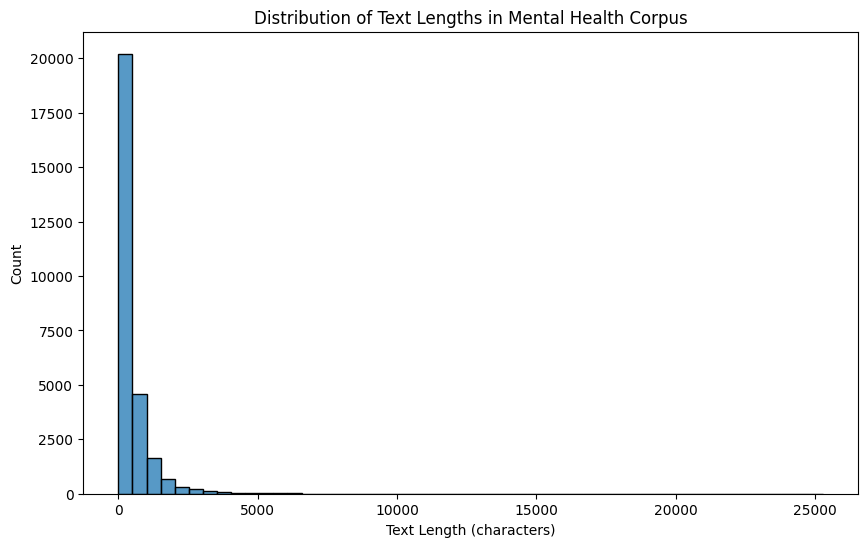

In [9]:
# Explore the Mental Health Corpus dataset
print("Mental Health Corpus Labels:") 
print(mental_health_posts_df['label'].value_counts()) 

# Check text lengths
mental_health_posts_df['text_length'] = mental_health_posts_df['text'].apply(len) 
mental_health_posts_df['text_length'] = mental_health_posts_df['text_length'].replace([np.inf, -np.inf], np.nan)

plt.figure(figsize=(10, 6))
sns.histplot(mental_health_posts_df['text_length'].dropna(), bins=50) 
plt.title('Distribution of Text Lengths in Mental Health Corpus') 
plt.ylabel('Count')
plt.xlabel('Text Length (characters)') 
plt.show()

Suicide Prevention Dataset Class Distribution:
class
suicide        116037
non-suicide    116037
Name: count, dtype: int64


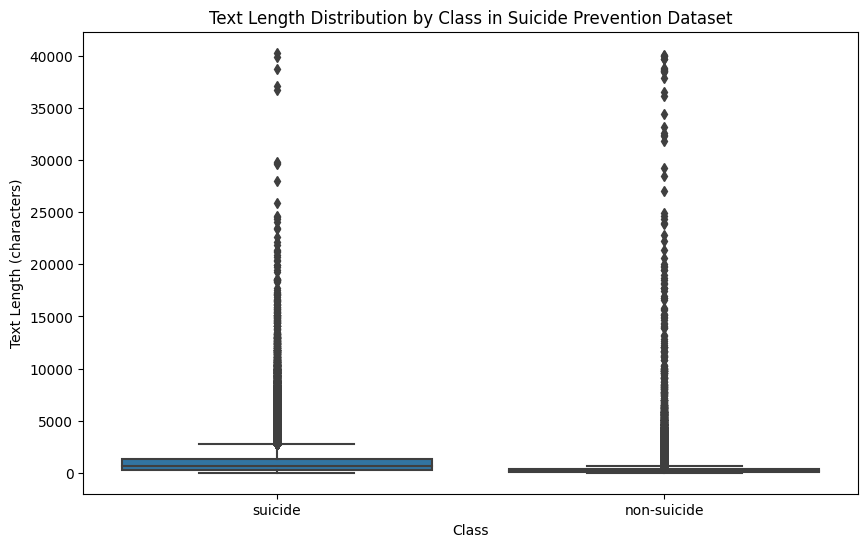

In [10]:
# Explore the Suicide Prevention dataset
print("Suicide Prevention Dataset Class Distribution:")
print(suicide_prevention_df['class'].value_counts())

# Text length distribution
suicide_prevention_df['text_length'] = suicide_prevention_df['text'].apply(len)
suicide_prevention_df['text_length'] = suicide_prevention_df['text_length'].replace([np.inf, -np.inf], np.nan)

plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='text_length', data=suicide_prevention_df.dropna(subset=['text_length']))
plt.title('Text Length Distribution by Class in Suicide Prevention Dataset')
plt.xlabel('Class')
plt.ylabel('Text Length (characters)')
plt.show()

## Data Preprocessing

Let's prepare our datasets for analysis.

In [11]:
# Function to clean text data
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^\w\s]', '', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ''

In [12]:
# Preprocess the Mental Health Corpus dataset
mental_health_posts_df['cleaned_text'] = mental_health_posts_df['text'].apply(clean_text)

# Preprocess the Suicide Prevention dataset
suicide_prevention_df['cleaned_text'] = suicide_prevention_df['text'].apply(clean_text)

# Display sample of cleaned data from Mental Health Corpus
print("Sample of cleaned mental health text:")
for i, row in mental_health_posts_df[['cleaned_text', 'label']].head(3).iterrows():
    print(f"Label: {row['label']}")
    print(f"Text: {row['cleaned_text'][:200]}...\n")

Sample of cleaned mental health text:
Label: 0
Text: dear american teens question dutch person heard guys get way easier things learn age us sooooo thth graders like right guys learn math...

Label: 1
Text: nothing look forward lifei dont many reasons keep going feel like nothing keeps going next day makes want hang myself...

Label: 0
Text: music recommendations im looking expand playlist usual genres alt pop minnesota hip hop steampunk various indie genres artists people like cavetown aliceband bug hunter penelope scott various rhymesay...



## Gen AI Capability 1: Structured Output/JSON Mode

Let's use Gemini's structured output capability to analyze and categorize mental health text data. This function will form a key node in our LangGraph agent.

In [13]:
# Define the structured output schema for mental health text analysis
analysis_schema = genai.types.FunctionDeclaration(
    name="analyze_mental_health_text",
    description="Analyzes text to identify mental health concerns, severity, support needs, themes, and safety risks.",
    parameters={
        'type_': 'OBJECT',
        'properties': {
            'primary_concern': {'type': 'STRING', 'description': "The main mental health concern identified (e.g., depression, anxiety, stress, trauma, addiction, eating_disorder, self_harm, suicidal_ideation, bipolar, schizophrenia, other, none).", 'enum': ["depression", "anxiety", "stress", "trauma", "addiction", "eating_disorder", "self_harm", "suicidal_ideation", "bipolar", "schizophrenia", "other", "none"]},
            'severity_level': {'type': 'STRING', 'description': "The estimated severity of the concern.", 'enum': ["mild", "moderate", "severe", "crisis", "unclear"]},
            'support_needed': {'type': 'ARRAY', 'items': {'type': 'STRING'}, 'description': "Types of support that might be helpful (e.g., emotional_support, professional_help, crisis_intervention, information, coping_strategies, community_resources, peer_support)."},
            'key_themes': {'type': 'ARRAY', 'items': {'type': 'STRING'}, 'description': "Keywords or themes mentioned in the text."},
            'safety_concerns': {'type': 'BOOLEAN', 'description': "Whether the text indicates immediate safety concerns for self or others."},
            'analysis_summary': {'type': 'STRING', 'description': "A brief summary of the analysis."}
        },
        'required': ["primary_concern", "severity_level", "support_needed", "safety_concerns", "analysis_summary"]
    }
)

# Tool definition for the model
analysis_tool = genai.types.Tool(function_declarations=[analysis_schema])

In [14]:
# Function to analyze mental health text using the defined tool/schema (Restored Candidate Check)
def analyze_mental_health_text_tool(text: str) -> Dict[str, Any]:
    # Define the default result here for clarity
    default_result = {
        'primary_concern': 'unclear',
        'severity_level': 'unclear',
        'support_needed': [],
        'key_themes': [],
        'safety_concerns': False,
        'analysis_summary': 'Analysis failed: Could not process API response.'
    }
    
    prompt = f"Please analyze the following text for mental health concerns using the 'analyze_mental_health_text' tool. "
    prompt += f"Focus on identifying the primary concern, severity, support needs, key themes, and any safety risks. "
    prompt += f"Be cautious not to over-interpret normal emotional experiences. If safety concerns are present, flag them explicitly.\n\n"
    prompt += 'Text: "' + text + '"\n'
    
    response = model.generate_content(prompt, tools=[analysis_tool])
    
    # *** Crucial Check: Ensure candidates list is not empty before accessing it ***
    if not response.candidates:
        print("Warning: API response contained no candidates. Returning default analysis.")
        # Check for prompt feedback which might indicate blocking
        if hasattr(response, 'prompt_feedback') and response.prompt_feedback:
             print(f"Prompt Feedback: {response.prompt_feedback}")
        return default_result
        
    # Find the function call part
    fc = None
    args = None
    # Access the first candidate now that we know it exists
    candidate = response.candidates[0]
    # Check candidate content and parts exist
    if hasattr(candidate, 'content') and candidate.content and hasattr(candidate.content, 'parts') and candidate.content.parts:
        for part in candidate.content.parts:
            if hasattr(part, 'function_call') and part.function_call and part.function_call.name == "analyze_mental_health_text":
                fc = part.function_call
                args = fc.args if hasattr(fc, 'args') and fc.args is not None else {}
                break
            
    if fc is None or args is None:
        print("Warning: No valid function call 'analyze_mental_health_text' found in model response parts.")
        # Check for finish reason which might indicate blocking or other issues
        if hasattr(candidate, 'finish_reason') and candidate.finish_reason:
             print(f"Candidate Finish Reason: {candidate.finish_reason}")
        if hasattr(candidate, 'safety_ratings') and candidate.safety_ratings:
             print(f"Candidate Safety Ratings: {candidate.safety_ratings}")
        return default_result

    # Extract results, providing defaults
    analysis_result = {
        'primary_concern': args.get('primary_concern', 'unclear'),
        'severity_level': args.get('severity_level', 'unclear'),
        'support_needed': list(args.get('support_needed', [])),
        'key_themes': list(args.get('key_themes', [])),
        'safety_concerns': bool(args.get('safety_concerns', False)),
        'analysis_summary': args.get('analysis_summary', 'Analysis summary missing.')
    }
    
    # Ensure list types just in case
    if not isinstance(analysis_result['support_needed'], list):
        analysis_result['support_needed'] = [analysis_result['support_needed']] if analysis_result['support_needed'] else []
    if not isinstance(analysis_result['key_themes'], list):
        analysis_result['key_themes'] = [analysis_result['key_themes']] if analysis_result['key_themes'] else []
        
    return analysis_result

In [15]:
# Test the structured output analysis using the tool function
sample_texts_tool = [
    # Sample 1 - Depression indication
    "I've been feeling really down for the past month. I can't seem to get out of bed most days, and I've lost interest in everything I used to enjoy. I'm sleeping too much but still feel exhausted all the time.",
    
    # Sample 2 - Anxiety indication
    "My heart keeps racing and I feel like something terrible is about to happen. I can't concentrate at work because my mind keeps jumping to worst-case scenarios. I've started avoiding social situations because I get so nervous.",
    
    # Sample 3 - Crisis indication
    "I don't see any point in continuing anymore. I've written notes to my family. No one would really miss me anyway. I've been thinking about the best way to end things."
]

for i, text in enumerate(sample_texts_tool):
    print(f"Sample {i+1}:")
    print(f"Text: {text}")
    analysis = analyze_mental_health_text_tool(text)
    print("\nAnalysis (Tool Output):")
    # Pretty print the dictionary
    print(json.dumps(analysis, indent=2))
    print("\n" + "-"*80 + "\n")

Sample 1:
Text: I've been feeling really down for the past month. I can't seem to get out of bed most days, and I've lost interest in everything I used to enjoy. I'm sleeping too much but still feel exhausted all the time.

Analysis (Tool Output):
{
  "primary_concern": "depression",
  "severity_level": "moderate",
  "support_needed": [
    "professional_help",
    "emotional_support",
    "coping_strategies",
    "information"
  ],
  "key_themes": [
    "low_mood",
    "loss_of_interest",
    "fatigue",
    "oversleeping",
    "low_motivation"
  ],
  "safety_concerns": false,
  "analysis_summary": "The user reports experiencing persistent low mood, loss of interest, excessive sleep despite fatigue, and difficulty getting out of bed for the past month, suggesting potential depression."
}

--------------------------------------------------------------------------------

Sample 2:
Text: My heart keeps racing and I feel like something terrible is about to happen. I can't concentrate at wo

## Gen AI Capability 2: Retrieval Augmented Generation (RAG)

Let's implement a simple RAG system using the Gemini API for embeddings and ChromaDB. This will provide context for our LangGraph agent.

In [16]:
# Create a collection of mental health information from reliable sources
mental_health_documents = [
    # Document 1: Depression information from Mayo Clinic
    """Depression is a mood disorder that causes a persistent feeling of sadness and loss of interest. Also called major depressive disorder or clinical depression, it affects how you feel, think and behave and can lead to a variety of emotional and physical problems. You may have trouble doing normal day-to-day activities, and sometimes you may feel as if life isn't worth living. More than just a bout of the blues, depression isn't a weakness and you can't simply 'snap out' of it. Depression may require long-term treatment. But don't get discouraged. Most people with depression feel better with medication, psychotherapy or both. Depression symptoms can vary from mild to severe and may include: Feeling sad or having a depressed mood, Loss of interest or pleasure in activities once enjoyed, Changes in appetite — weight loss or gain unrelated to dieting, Trouble sleeping or sleeping too much, Loss of energy or increased fatigue, Increase in purposeless physical activity or slowed movements and speech, Feeling worthless or guilty, Difficulty thinking, concentrating or making decisions, Thoughts of death or suicide""",
    
    # Document 2: Anxiety information from NIMH
    """Anxiety disorders are characterized by excessive worry, nervousness, or fear that is difficult to control and interferes with daily activities. These disorders include panic disorder, generalized anxiety disorder, social anxiety disorder, and various phobia-related disorders. Common symptoms of anxiety include: Feeling restless, wound-up, or on-edge, Being easily fatigued, Having difficulty concentrating, Being irritable, Having headaches, muscle aches, stomachaches, or unexplained pains, Difficulty controlling feelings of worry, Having sleep problems, such as difficulty falling or staying asleep. Effective treatments for anxiety disorders include psychotherapy (particularly cognitive-behavioral therapy), medication, or a combination of the two. Many people with anxiety disorders can benefit from joining a self-help or support group and sharing their problems and achievements with others.""",
    
    # Document 3: Crisis intervention from American Foundation for Suicide Prevention
    """If you or someone you know is in crisis, contact the 988 Suicide & Crisis Lifeline that provides 24/7, free and confidential support. Call or text 988, or chat at 988lifeline.org. For emergency situations, call 911 or visit your local emergency room. Warning signs of suicide may include: Talking about wanting to die or to kill oneself, Looking for ways to kill oneself, such as searching online or buying a gun, Talking about feeling hopeless or having no reason to live, Talking about feeling trapped or in unbearable pain, Talking about being a burden to others, Increasing use of alcohol or drugs, Acting anxious or agitated; behaving recklessly, Sleeping too little or too much, Withdrawing or feeling isolated, Showing rage or talking about seeking revenge, Displaying extreme mood swings. If someone is showing these warning signs, don't leave them alone, remove potential means of harm, and call the crisis line or take them to an emergency room.""",
    
    # Document 4: Coping strategies from APA
    """Healthy coping strategies for managing stress and mental health challenges include: 1. Practice relaxation techniques: Deep breathing, meditation, progressive muscle relaxation. 2. Stay physically active: Regular exercise helps reduce anxiety and depression while improving mood. 3. Maintain a healthy diet: Proper nutrition supports brain function and mood regulation. 4. Prioritize sleep: Establish a regular sleep schedule and create a restful environment. 5. Connect with others: Social support is crucial for mental wellbeing. 6. Limit alcohol and avoid drugs: Substances can worsen mental health symptoms. 7. Set realistic goals: Break large tasks into smaller, manageable steps. 8. Practice self-compassion: Treat yourself with the same kindness you would offer a friend. 9. Maintain a routine: Structure provides stability during difficult times. 10. Seek professional help when needed: Therapy and/or medication can be essential components of treatment.""",
    
    # Document 5: Workplace mental health
    """Creating mentally healthy workplaces involves: 1. Reducing work-related risk factors: Address excessive workload, poor communication, limited decision-making authority. 2. Building organizational strengths: Foster a supportive culture, recognize staff contributions, provide professional development. 3. Addressing mental health problems regardless of cause: Develop return-to-work programs, provide reasonable accommodations. 4. Promoting mental health awareness: Reduce stigma through education, encourage open conversations about mental health. 5. Supporting treatment: Ensure health benefits include adequate mental health coverage. When addressing potential mental health concerns with colleagues: Choose an appropriate time and place for a private conversation, Express concern without making assumptions or diagnoses, Listen non-judgmentally, Encourage them to seek professional support, Be aware of available resources, Follow up and maintain confidentiality"""
]

In [17]:
# Set up a simple document chunking function
def split_into_chunks(text, chunk_size=500, overlap=100):
    chunks = []
    start = 0
    text_length = len(text)
    
    while start < text_length:
        end = min(start + chunk_size, text_length)
        # Try to end on a sentence boundary if possible within a reasonable range
        if end < text_length:
            period_pos = text.rfind('.', start + chunk_size - overlap, end)
            if period_pos != -1:
                end = period_pos + 1
            else: # Fallback to space if no period found
                space_pos = text.rfind(' ', start + chunk_size - overlap, end)
                if space_pos != -1:
                    end = space_pos + 1
        
        chunk = text[start:end].strip()
        if chunk:  # Only add non-empty chunks
            chunks.append(chunk)
        
        # Move start position for the next chunk, considering overlap
        start = max(end - overlap, start + 1) 
            
    return chunks

# Chunk all documents
all_chunks = []
for i, doc in enumerate(mental_health_documents):
    chunks = split_into_chunks(doc)
    # Add metadata (document source) to each chunk
    for j, chunk in enumerate(chunks):
        all_chunks.append({"id": f"doc_{i}_chunk_{j}", "text": chunk, "source": f"Document {i+1}"})

print(f"Total chunks created: {len(all_chunks)}")
if all_chunks:
    print("\nSample chunk:")
    print(all_chunks[0])

Total chunks created: 515

Sample chunk:
{'id': 'doc_0_chunk_0', 'text': "Depression is a mood disorder that causes a persistent feeling of sadness and loss of interest. Also called major depressive disorder or clinical depression, it affects how you feel, think and behave and can lead to a variety of emotional and physical problems. You may have trouble doing normal day-to-day activities, and sometimes you may feel as if life isn't worth living. More than just a bout of the blues, depression isn't a weakness and you can't simply 'snap out' of it.", 'source': 'Document 1'}


In [18]:
# Function to get embeddings using Gemini API (Simplified Error Handling)
embedding_model_name = "models/embedding-001"
def get_embeddings(texts, task_type="retrieval_document"):
    result = genai.embed_content(
        model=embedding_model_name,
        content=texts,
        task_type=task_type
    )
    return result['embedding']

# Get embeddings for all chunks
chunk_texts = [chunk['text'] for chunk in all_chunks]
chunk_embeddings = get_embeddings(chunk_texts)

# Create lists for Chroma
filtered_chunks = all_chunks
filtered_embeddings = chunk_embeddings
filtered_chunk_texts = chunk_texts
filtered_ids = [chunk['id'] for chunk in filtered_chunks]
filtered_metadatas = [{"source": chunk['source']} for chunk in filtered_chunks]

print(f"Number of chunks with embeddings: {len(filtered_chunks)}")
if filtered_embeddings: # Check if embeddings list is not empty
    print(f"Dimension of embeddings: {len(filtered_embeddings[0])}")
else:
    print("No embeddings were generated.")

Number of chunks with embeddings: 515
Dimension of embeddings: 768


In [19]:
# Set up ChromaDB client and collection (Keeping Error Handling Here)
collection = None # Initialize collection to None
try:
    chroma_client = chromadb.Client()
    collection_name = "mental_health_info"
    
    # Attempt to delete the collection if it exists, before creating
    try:
        chroma_client.delete_collection(name=collection_name)
        print(f"Existing collection '{collection_name}' deleted.")
    except Exception as delete_err:
        # Ignore if deletion fails (e.g., collection doesn't exist)
        print(f"Note: Could not delete collection '{collection_name}' (may not exist): {delete_err}")
        
    # Create the collection
    collection = chroma_client.create_collection(name=collection_name)
    
    # Add documents and embeddings to the collection
    if filtered_embeddings and filtered_chunk_texts and filtered_metadatas and filtered_ids:
        collection.add(
            embeddings=filtered_embeddings,
            documents=filtered_chunk_texts,
            metadatas=filtered_metadatas,
            ids=filtered_ids
        )
        print(f"Added {collection.count()} documents to the ChromaDB collection.")
    else:
        print("Skipping ChromaDB add: Missing embeddings, texts, metadatas, or ids.")
        collection = None # Ensure collection is None if add fails
        
except Exception as e:
    print(f"Error setting up ChromaDB: {e}")
    # collection remains None if setup fails

Note: Could not delete collection 'mental_health_info' (may not exist): Collection mental_health_info does not exist.
Added 515 documents to the ChromaDB collection.


In [20]:
# Function to retrieve relevant information using ChromaDB (Simplified Error Handling)
def retrieve_relevant_info_rag(query: str, top_k: int = 3) -> str:
    if collection is None:
        print("Warning: ChromaDB collection not available for RAG.")
        return "[Error: ChromaDB collection not available]"    
    
    # Get embedding for the query
    query_embedding = get_embeddings([query], task_type="retrieval_query")[0]
        
    # Query the collection
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k,
        include=['documents', 'metadatas', 'distances']
    )
    
    # Format the results
    context = ""
    if results and results.get('documents') and results['documents'][0]:
        context += "Relevant Information Found:\n"
        for i, doc in enumerate(results['documents'][0]):
            source = results['metadatas'][0][i].get('source', 'Unknown Source')
            distance = results['distances'][0][i]
            # Simple relevance filter based on distance
            if distance < 1.5: # Lower distance usually means more relevant
                context += f"---\nSource: {source}\nContent: {doc}\n(Relevance Score: {1 / (1 + distance):.2f})\n"
    
    return context.strip() or "[No relevant information found]"

In [21]:
# Test the RAG retrieval function
test_query = "I'm feeling very anxious and having trouble sleeping. What can I do?"
retrieved_info = retrieve_relevant_info_rag(test_query)

print(f"Query: {test_query}\n")
print("Retrieved Information (RAG Function Test):")
print(retrieved_info)

Query: I'm feeling very anxious and having trouble sleeping. What can I do?

Retrieved Information (RAG Function Test):
Relevant Information Found:
---
Source: Document 2
Content: Anxiety disorders are characterized by excessive worry, nervousness, or fear that is difficult to control and interferes with daily activities. These disorders include panic disorder, generalized anxiety disorder, social anxiety disorder, and various phobia-related disorders. Common symptoms of anxiety include: Feeling restless, wound-up, or on-edge, Being easily fatigued, Having difficulty concentrating, Being irritable, Having headaches, muscle aches, stomachaches, or unexplained pains,
(Relevance Score: 0.62)
---
Source: Document 2
Content: concentrating, Being irritable, Having headaches, muscle aches, stomachaches, or unexplained pains, Difficulty controlling feelings of worry, Having sleep problems, such as difficulty falling or staying asleep. Effective treatments for anxiety disorders include psychoth

## Gen AI Capability 3: Few-Shot Prompting for Response Generation

This prompt structure will be used by the response generation node in our LangGraph agent.

In [22]:
# Define the base prompt structure for response generation
FEW_SHOT_RESPONSE_PROMPT_TEMPLATE = """
You are an empathetic and supportive mental health assistant. 
Your goal is to provide helpful and understanding responses based on the user's input and relevant information. 
Do NOT diagnose. Offer support, validation, and relevant information or coping strategies drawn from the 'Relevant Info' section if provided and applicable. 
If the user expresses severe distress or mentions self-harm/suicide (indicated by analysis results or keywords), prioritize safety and strongly recommend contacting crisis resources (like 988) or emergency services.

--- Analysis Results ---
{analysis_results_str}

--- Relevant Info ---
{retrieved_context}

--- User Input ---
{user_input}

--- Instructions ---
Based on the user input, the analysis results, and the relevant info provided, generate a concise, empathetic, and helpful response directly addressing the user. 
1. Acknowledge the user's feelings.
2. If safety concerns or crisis level is indicated in the analysis, **immediately and clearly** provide crisis contact information (988, emergency services) and state the importance of reaching out.
3. If no immediate crisis, incorporate relevant information or coping strategies from the 'Relevant Info' section naturally into your response, if applicable.
4. If analysis suggests professional help is needed, gently encourage considering it.
5. Keep the tone supportive and conversational. Avoid sounding robotic or just listing information.
6. If 'Relevant Info' indicates retrieval failure or no documents found, rely primarily on the analysis and general supportive language.

Response:
"""

# Function to generate a supportive response (Simplified Error Handling)
def generate_support_response_llm(user_input: str, retrieved_context: str, analysis_results: Dict[str, Any]) -> str:
    # Format analysis results for the prompt
    analysis_results_str = json.dumps(analysis_results, indent=2)
    
    prompt = FEW_SHOT_RESPONSE_PROMPT_TEMPLATE.format(
        user_input=user_input,
        retrieved_context=retrieved_context,
        analysis_results_str=analysis_results_str
    )
    
    # Generate the response using the main model
    response = model.generate_content(prompt)
    
    # Simplified response extraction
    try:
        # Check for empty candidates list first
        if not response.candidates:
            print("Warning: LLM response contained no candidates.")
            if hasattr(response, 'prompt_feedback') and response.prompt_feedback:
                print(f"Prompt Feedback: {response.prompt_feedback}")
            return "I'm here to listen. Could you tell me a bit more?" # Fallback
        # Check if text attribute exists directly (common case)
        if hasattr(response, 'text') and response.text:
            return response.text
        # Fallback to checking parts if .text doesn't exist
        if response.candidates[0].content and response.candidates[0].content.parts:
             return response.candidates[0].content.parts[0].text
        # If no text found anywhere
        print("Warning: Could not extract text from LLM response parts.")
        return "I'm here to listen. Could you tell me a bit more?" # Fallback
    except Exception as e:
        print(f"Warning: Could not extract text from response: {e}")
        # Provide a minimal fallback if text extraction fails
        return "I'm here to listen. Could you tell me a bit more?"

In [23]:
# Test the few-shot response generation function
test_input_fewshot = "I had a panic attack yesterday and I'm scared it will happen again. My chest gets tight and I can't breathe."
test_analysis = analyze_mental_health_text_tool(test_input_fewshot)
test_retrieved_context = retrieve_relevant_info_rag(test_input_fewshot, top_k=2)
support_response = generate_support_response_llm(test_input_fewshot, test_retrieved_context, test_analysis)

print(f"User Input: {test_input_fewshot}\n")
print(f"Analysis:\n{json.dumps(test_analysis, indent=2)}\n")
print(f"Retrieved Context:\n{test_retrieved_context}\n")
print("Generated Support Response:")
display(Markdown(support_response))

User Input: I had a panic attack yesterday and I'm scared it will happen again. My chest gets tight and I can't breathe.

Analysis:
{
  "primary_concern": "anxiety",
  "severity_level": "moderate",
  "support_needed": [
    "emotional_support",
    "coping_strategies",
    "information"
  ],
  "key_themes": [
    "panic attack",
    "fear",
    "chest tightness",
    "breathing difficulty"
  ],
  "safety_concerns": false,
  "analysis_summary": "User described experiencing a panic attack with physical symptoms (chest tightness, difficulty breathing) and expressed fear of recurrence, suggesting anxiety related to panic."
}

Retrieved Context:
Relevant Information Found:
---
Source: Document 2
Content: Anxiety disorders are characterized by excessive worry, nervousness, or fear that is difficult to control and interferes with daily activities. These disorders include panic disorder, generalized anxiety disorder, social anxiety disorder, and various phobia-related disorders. Common symptom

Oh, that sounds really frightening. Experiencing a panic attack like that, with the chest tightness and difficulty breathing, can be incredibly scary, and it's completely understandable why you'd be worried about it happening again. Those physical sensations are very real and distressing when they occur.

Feeling worried or on-edge after such an intense experience is common with anxiety. Sometimes, understanding more about these feelings can help. Many people find that learning specific coping techniques, perhaps through therapy like Cognitive Behavioral Therapy (CBT) or even joining a support group where you can share experiences, can make a big difference in managing these fears and the physical symptoms.

If these feelings continue or feel overwhelming, talking to a doctor or a mental health professional could provide you with more personalized support and strategies to help you cope when those feelings arise. You don't have to go through this alone.

## Gen AI Capability 4: Long Context Window (Simulated Conversation)

Let's simulate a conversation where the model maintains context over multiple turns using Gemini's long context capability implicitly via `genai.ChatSession`. Note that this is separate from the LangGraph agent, which processes one input at a time based on its defined graph structure.

In [24]:
# Start a chat session (Simplified Error Handling)
chat = model.start_chat(history=[])
print("Chat session started. Simulating a few turns.")

# Define initial context for the chat model
initial_message = {
    'role': 'user',
    'parts': ["You are a supportive mental health assistant. Use the principles from the few-shot examples: be empathetic, don't diagnose, offer support and relevant information (like coping strategies), and prioritize safety if crisis signs appear. Keep responses concise and conversational."]
}
model_ack = {
    'role': 'model',
    'parts': ["Understood. I will act as a supportive mental health assistant, following those guidelines. How can I help you today?"]
}

# Initialize history
chat.history = [initial_message, model_ack]

# Simulate conversation loop
conversation_turns = [
    "I've been feeling really anxious about an upcoming presentation.",
    "Thanks, that's helpful. What are some quick grounding techniques I could use if I feel overwhelmed just before?",
    "Okay, I'll try the 5-4-3-2-1 technique. It's just hard because I feel like everyone will judge me.",
    "That's a good reminder. I appreciate you listening."
]

for turn in conversation_turns:
    print(f"\nUser: {turn}")
    
    # Send message to the chat model
    response = chat.send_message(turn)
    
    print(f"\nAssistant:")
    # Add check for candidates before accessing text
    try:
        if response.text:
             display(Markdown(response.text))
        elif response.candidates:
             # Fallback if .text isn't directly available
             display(Markdown(response.candidates[0].content.parts[0].text))
        else:
             print("[No response generated or candidates found]")
             if hasattr(response, 'prompt_feedback') and response.prompt_feedback:
                 print(f"Prompt Feedback: {response.prompt_feedback}")
    except Exception as e:
         print(f"[Error displaying response: {e}]")

Chat session started. Simulating a few turns.

User: I've been feeling really anxious about an upcoming presentation.

Assistant:


Okay, that sounds really understandable. Presentations can definitely bring up those anxious feelings for a lot of people. It takes courage to face them.

Would it help to talk a bit more about what specifically feels worrying, or maybe explore some simple grounding techniques that can help manage anxiety in the moment?


User: Thanks, that's helpful. What are some quick grounding techniques I could use if I feel overwhelmed just before?

Assistant:


Okay, absolutely. Having some quick tools ready can make a big difference. Here are a couple you could try right before you go on:

1.  **Deep Breathing:** Try slowly breathing in through your nose for 4 seconds, holding for 4, and exhaling slowly through your mouth for 6. Repeat this a few times. It helps calm your nervous system.
2.  **5-4-3-2-1 Senses:** Quickly notice:
    *   5 things you can **see** around you.
    *   4 things you can **touch** (your clothes, the chair).
    *   3 things you can **hear**.
    *   2 things you can **smell**.
    *   1 thing you can **taste**. This pulls your focus to the present moment.
3.  **Physical Grounding:** Simply press your feet firmly into the floor. Notice the sensation of the ground supporting you. You can also try clenching and unclenching your fists.

These are just meant to interrupt the anxious spiral for a moment and bring you back to the here and now. Would you like to explore any of these a bit more?


User: Okay, I'll try the 5-4-3-2-1 technique. It's just hard because I feel like everyone will judge me.

Assistant:


That's a really common and tough feeling – the fear of being judged can definitely amplify anxiety. It makes sense you'd feel that way when you're putting yourself out there.

Sometimes it helps to gently challenge that thought. While the *feeling* of being judged is very strong, often people are more focused on the information you're sharing, or even just thinking about their own day.

Perhaps focusing on your preparation and the message you want to convey, rather than trying to guess others' thoughts, could help shift your focus slightly? It's about reminding yourself *why* you're doing the presentation.


User: That's a good reminder. I appreciate you listening.

Assistant:


You're very welcome. I'm really glad I could listen and offer some ideas. It takes courage to reach out and think about managing those tough feelings.

Remember those techniques, and please feel free to reach out anytime if you want to talk more, whether it's about the presentation or anything else. I'm here to support you.

## Gen AI Capability 5: Document Understanding (Example)

Let's demonstrate how Gemini can analyze and summarize a piece of text, simulating the analysis of mental health literature.

In [25]:
# Sample text simulating a research abstract or article section
document_text = """
Abstract: Cognitive Behavioral Therapy (CBT) remains a cornerstone in the treatment of anxiety disorders. 
This meta-analysis reviews 50 randomized controlled trials (RCTs) published between 2015 and 2023, 
evaluating the efficacy of CBT compared to control conditions (waitlist, placebo, treatment-as-usual) 
for Generalized Anxiety Disorder (GAD), Panic Disorder (PD), and Social Anxiety Disorder (SAD). 
Results indicate large effect sizes (Cohen's d > 0.8) for CBT across all three disorders, 
with significant reductions in primary symptom measures post-treatment and at 6-month follow-up. 
Moderator analyses suggest that therapist experience and treatment duration positively influence outcomes. 
While digital delivery of CBT shows promise, particularly for accessibility, effect sizes were slightly smaller 
compared to face-to-face therapy (d = 0.7 vs d = 0.9). Dropout rates were comparable across delivery formats. 
Future research should focus on personalized CBT approaches and long-term efficacy beyond 12 months.
Limitations include heterogeneity in control conditions and outcome measures across studies.
"""

# Prompt for document analysis
analysis_prompt = f"""
Analyze the following research abstract. Provide:
1. A concise summary of the main findings.
2. Key strengths of the research mentioned.
3. Key limitations mentioned.
4. Future research directions suggested.

Abstract:
{document_text}

Analysis:
"""

# Generate the analysis (Simplified Error Handling)
analysis_response = model.generate_content(analysis_prompt)

print("Document Text:")
print(document_text)
print("\nGenerated Analysis:")
# Add check for candidates before accessing text
try:
    if analysis_response.text:
        display(Markdown(analysis_response.text))
    elif analysis_response.candidates:
        display(Markdown(analysis_response.candidates[0].content.parts[0].text))
    else:
        print("[No analysis generated or candidates found]")
        if hasattr(analysis_response, 'prompt_feedback') and analysis_response.prompt_feedback:
            print(f"Prompt Feedback: {analysis_response.prompt_feedback}")
except Exception as e:
    print(f"[Error displaying analysis: {e}]")

Document Text:

Abstract: Cognitive Behavioral Therapy (CBT) remains a cornerstone in the treatment of anxiety disorders. 
This meta-analysis reviews 50 randomized controlled trials (RCTs) published between 2015 and 2023, 
evaluating the efficacy of CBT compared to control conditions (waitlist, placebo, treatment-as-usual) 
for Generalized Anxiety Disorder (GAD), Panic Disorder (PD), and Social Anxiety Disorder (SAD). 
Results indicate large effect sizes (Cohen's d > 0.8) for CBT across all three disorders, 
with significant reductions in primary symptom measures post-treatment and at 6-month follow-up. 
Moderator analyses suggest that therapist experience and treatment duration positively influence outcomes. 
While digital delivery of CBT shows promise, particularly for accessibility, effect sizes were slightly smaller 
compared to face-to-face therapy (d = 0.7 vs d = 0.9). Dropout rates were comparable across delivery formats. 
Future research should focus on personalized CBT approac

Here is an analysis of the provided research abstract:

1.  **Concise Summary of Main Findings:**
    This meta-analysis of 50 recent RCTs confirms that Cognitive Behavioral Therapy (CBT) is highly effective (large effect sizes, d > 0.8) for treating Generalized Anxiety Disorder, Panic Disorder, and Social Anxiety Disorder compared to control conditions. These positive effects are maintained at 6-month follow-up. Therapist experience and longer treatment duration enhance outcomes. While digital CBT is a viable and accessible option, it yielded slightly smaller effect sizes than face-to-face CBT (d=0.7 vs d=0.9), though dropout rates were similar.

2.  **Key Strengths Mentioned:**
    *   **Robust Methodology:** Uses a meta-analysis, synthesizing data from multiple studies.
    *   **High-Quality Evidence:** Based on Randomized Controlled Trials (RCTs), the gold standard for evaluating treatment efficacy.
    *   **Large Sample:** Includes a significant number of studies (50 RCTs).
    *   **Recency:** Focuses on recently published studies (2015-2023), reflecting current practices.
    *   **Quantitative Effect Sizes:** Reports specific effect sizes (Cohen's d), indicating the magnitude of the treatment effect.
    *   **Follow-up Data:** Includes 6-month follow-up data, assessing the durability of treatment effects.
    *   **Moderator Analysis:** Investigates factors that may influence treatment outcomes (therapist experience, duration, delivery format).

3.  **Key Limitations Mentioned:**
    *   **Heterogeneity in Control Conditions:** The control groups used across the included studies varied (waitlist, placebo, treatment-as-usual), which can complicate comparisons.
    *   **Heterogeneity in Outcome Measures:** The specific tools or methods used to measure anxiety symptoms differed between studies, potentially affecting the pooled results.

4.  **Future Research Directions Suggested:**
    *   **Personalized CBT:** Focus on developing and evaluating CBT approaches tailored to individual patient characteristics or needs.
    *   **Long-Term Efficacy:** Investigate the effectiveness of CBT over longer periods, specifically beyond 12 months, to better understand the durability of treatment gains.

## Exploratory Data Analysis (EDA) Visualization

Let's add a simple visualization based on the loaded data.

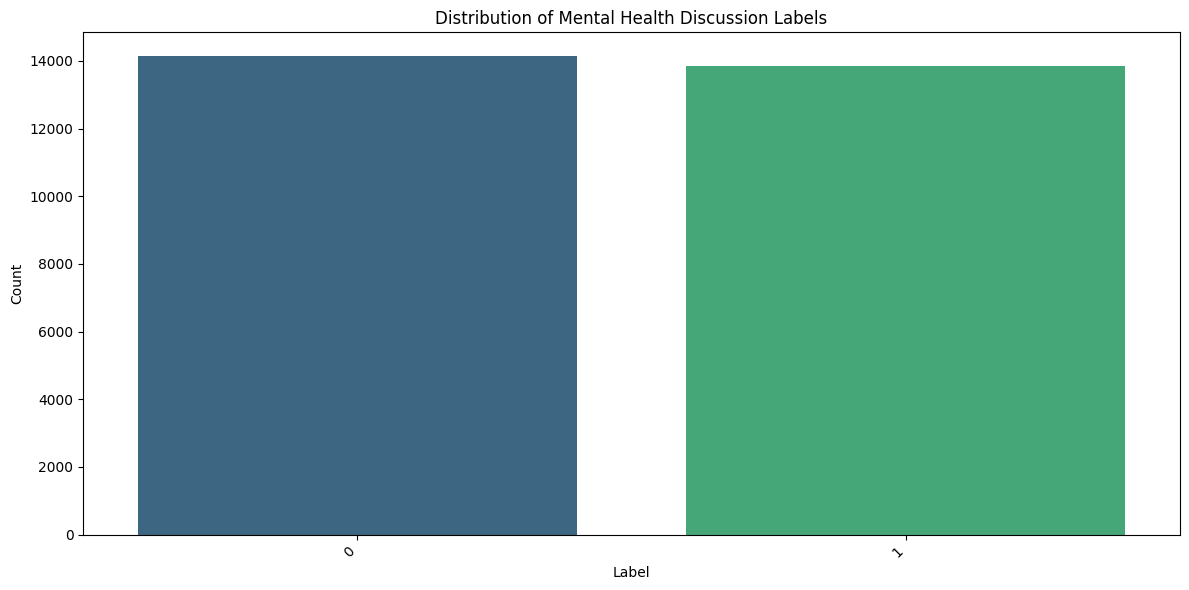

In [26]:
# Visualize distribution of labels in the Mental Health Corpus (Simplified Error Handling)
plt.figure(figsize=(12, 6))
label_counts = mental_health_posts_df['label'].value_counts().dropna()

sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title('Distribution of Mental Health Discussion Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Gen AI Capability 6: Agentic Workflow with LangGraph

Now, let's implement the mental health support agent using LangGraph. This allows us to define a structured workflow (a graph) where different components (nodes) are executed based on the state of the conversation.

**Workflow Steps:**
1.  **Analyze Input:** Use the `analyze_mental_health_text_tool` function to understand the user's message (concern, severity, safety).
2.  **Route:** Based on the analysis, decide whether to retrieve information or go directly to generating a response.
    *   If crisis/severe/moderate/mild with themes: Retrieve relevant info using RAG (`retrieve_relevant_info_rag`).
    *   Otherwise: Proceed to generate response with empty context.
3.  **Generate Response:** Use the LLM (`generate_support_response_llm`) with the original input, analysis results, and any retrieved context to create the final supportive message.

In [27]:
# Define the state for our LangGraph agent
class MentalHealthAgentState(TypedDict):
    user_input: str
    analysis_results: Dict[str, Any] # Output from analyze_mental_health_text_tool
    retrieved_context: str
    final_response: str
    # routing_decision is no longer needed in the state if route_decider returns the next node directly
    # routing_decision: str

In [28]:
# Define the nodes for the LangGraph agent

def analyze_input_node(state: MentalHealthAgentState) -> Dict[str, Any]:
    """Analyzes the user input using the structured output tool."""
    print("--- Node: Analyzing Input ---")
    user_input = state['user_input']
    analysis = analyze_mental_health_text_tool(user_input)
    print(f"Analysis Result: {json.dumps(analysis, indent=2)}")
    # Return the analysis results to update the state
    return {"analysis_results": analysis}

def retrieve_info_node(state: MentalHealthAgentState) -> Dict[str, str]:
    """Retrieves relevant information based on analysis results."""
    print("--- Node: Retrieving Information (RAG) ---")
    analysis = state.get('analysis_results', {})
    primary_concern = analysis.get('primary_concern', 'general concern')
    key_themes = analysis.get('key_themes', []) 
    severity = analysis.get('severity_level', 'unclear')
    safety_concerns = analysis.get('safety_concerns', False)
    
    # Construct query based on analysis
    # Prioritize crisis/safety query
    if safety_concerns or severity == 'crisis':
        query = "crisis intervention contact information and immediate safety steps"
        top_k = 1
    # Construct query for other cases needing retrieval
    elif severity in ['severe', 'moderate', 'mild'] or key_themes:
        theme_str = f"Key themes: {', '.join(key_themes)}" if key_themes else ""
        if severity in ['severe', 'moderate']:
            query = f"{primary_concern} coping strategies and professional help information. {theme_str}"
            top_k = 2
        elif severity == 'mild':
            query = f"mild {primary_concern} coping strategies. {theme_str}"
            top_k = 1
        else: # Only themes present
             query = f"Information related to {', '.join(key_themes)}"
             top_k = 1
    else:
         print("No specific query for retrieval based on analysis.")
         return {"retrieved_context": "[No specific information retrieved as analysis was unclear and no key themes identified]"}
             
    print(f"Retrieval Query: {query}")
    context = retrieve_relevant_info_rag(query, top_k=top_k)
    print(f"Retrieved Context:\n{context}")
    # Return the retrieved context to update the state
    return {"retrieved_context": context}

def generate_response_node(state: MentalHealthAgentState) -> Dict[str, str]:
    """Generates a supportive response based on input, analysis, and retrieved context."""
    print("--- Node: Generating Response ---")
    response = generate_support_response_llm(
        user_input=state['user_input'],
        retrieved_context=state.get('retrieved_context', '[No contextual information available]'),
        analysis_results=state['analysis_results']
    )
    # Return the final response to update the state
    return {"final_response": response}

# *** Corrected Routing Function: Returns only the next node name (string) ***
def route_decider(state: MentalHealthAgentState) -> str:
    """Determines the next node based on analysis results."""
    print("--- Route Decider --- ") 
    analysis = state.get('analysis_results', {})
    primary_concern = analysis.get('primary_concern', 'unclear')
    severity = analysis.get('severity_level', 'unclear')
    safety_concerns = analysis.get('safety_concerns', False)
    key_themes = analysis.get('key_themes', [])
    
    # Define routing logic
    # Ensure retrieval happens if concerns are identified, even without specific themes
    if safety_concerns or severity in ['crisis', 'severe', 'moderate'] or (primary_concern != 'unclear' and primary_concern != 'none'):
        decision = "retrieve_info"
    else:
        decision = "generate_response"
    
    print(f"Routing Decision: {decision}")
    # This function *only* returns the decision string for the conditional edge
    return decision

In [29]:
# Build the graph (Keeping Error Handling Here)
app = None # Initialize app to None
try:
    # Create the graph
    graph_builder = StateGraph(MentalHealthAgentState)
    
    # Add nodes
    graph_builder.add_node("analyze_input", analyze_input_node)
    graph_builder.add_node("retrieve_info", retrieve_info_node)
    graph_builder.add_node("generate_response", generate_response_node)
    
    # Set the entry point
    graph_builder.set_entry_point("analyze_input")

    # Add conditional edge directly from analyze_input using the route_decider function
    graph_builder.add_conditional_edges(
        "analyze_input", # Start node for branching
        route_decider,   # Function that returns the next node name (string)
        {
            "retrieve_info": "retrieve_info",       # If route_decider returns "retrieve_info", go to retrieve_info node
            "generate_response": "generate_response" # If route_decider returns "generate_response", go to generate_response node
        }
    )
    
    # Edges after branching
    graph_builder.add_edge("retrieve_info", "generate_response") # Always go to generate_response after retrieving info
    graph_builder.add_edge("generate_response", END) # End after generating response
    
    # Compile the graph
    app = graph_builder.compile()
    print("Graph compiled successfully")
    
except Exception as e:
    print(f"Error building LangGraph: {e}")

Graph compiled successfully


### Graph Visualization

The following diagram shows the structure of the agent:

In [30]:
# Visualize the graph (Simplified Error Handling)
try:
    # Ensure the app is compiled before trying to visualize
    if app:
        # Try PNG generation with timeout first
        mermaid_png = app.get_graph().draw_mermaid_png(timeout=30)
        display(Image(mermaid_png))
    else:
        print("Graph 'app' not compiled yet. Run the previous cell first.")
except Exception as e:
    print(f"Error visualizing graph as PNG (maybe timeout or network issue): {e}")
    print("Attempting to generate Mermaid text definition as fallback:")
    try:
        if app:
            mermaid_text = app.get_graph().draw_mermaid()
            print("\n```mermaid")
            print(mermaid_text)
            print("```\n(Copy the text above into a Markdown cell to render)")
        else:
             print("Graph 'app' not compiled, cannot generate Mermaid text.")
    except Exception as text_err:
        print(f"Could not generate Mermaid text either: {text_err}")

Error visualizing graph as PNG (maybe timeout or network issue): Graph.draw_mermaid_png() got an unexpected keyword argument 'timeout'
Attempting to generate Mermaid text definition as fallback:

```mermaid
%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	analyze_input(analyze_input)
	retrieve_info(retrieve_info)
	generate_response(generate_response)
	__end__([<p>__end__</p>]):::last
	__start__ --> analyze_input;
	generate_response --> __end__;
	retrieve_info --> generate_response;
	analyze_input -.-> retrieve_info;
	analyze_input -.-> generate_response;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc

```
(Copy the text above into a Markdown cell to render)


```mermaid
%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	analyze_input(analyze_input)
	retrieve_info(retrieve_info)
	generate_response(generate_response)
	__end__([<p>__end__</p>]):::last
	__start__ --> analyze_input;
	generate_response --> __end__;
	retrieve_info --> generate_response;
	analyze_input -.-> retrieve_info;
	analyze_input -.-> generate_response;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc

```

In [31]:
# Test the agent with a user input (Keeping invoke Error Handling)
def run_agent(user_input: str):
    if not app:
        print("Agent graph ('app') is not compiled. Cannot run.")
        return {"user_input": user_input, "final_response": "Error: Agent graph not compiled."}
        
    try:
        # Initialize state with user input
        initial_state = {"user_input": user_input}

        # Run the graph using invoke to get the final state directly
        final_state = app.invoke(initial_state)
        return final_state

    except Exception as e:
        print(f"Error running agent graph: {e}")
        # Return a fallback response in case of error during invoke
        return {
            "user_input": user_input, # Include original input for context
            "final_response": "I apologize, but I encountered an error while processing your request. Please try again later."
        }

# Test with a sample input (Simplified Error Handling)
test_input = "I've been feeling really down for over two weeks now. I can't sleep well, and I don't enjoy things I used to like. Should I be worried?"
final_state_result = run_agent(test_input) 

print("\n=== Final Response ===\n")
# Check if 'final_response' exists and is not empty
if final_state_result and "final_response" in final_state_result and final_state_result['final_response']:
    display(Markdown(final_state_result['final_response']))
else:
    # Provide a more informative message if no response was generated or state is missing
    print("No final response generated or final state is incomplete.")
    print(f"Final State Received: {final_state_result}") # Log the state for debugging

--- Node: Analyzing Input ---
Analysis Result: {
  "primary_concern": "depression",
  "severity_level": "moderate",
  "support_needed": [
    "professional_help",
    "information",
    "emotional_support"
  ],
  "key_themes": [
    "low mood",
    "anhedonia",
    "sleep disturbance",
    "duration (>2 weeks)"
  ],
  "safety_concerns": false,
  "analysis_summary": "The user reports feeling down for over two weeks, experiencing sleep disturbance, and loss of interest in previously enjoyed activities (anhedonia). These symptoms suggest potential depression. No immediate safety concerns are mentioned."
}
--- Route Decider --- 
Routing Decision: retrieve_info
--- Node: Retrieving Information (RAG) ---
Retrieval Query: depression coping strategies and professional help information. Key themes: low mood, anhedonia, sleep disturbance, duration (>2 weeks)
Retrieved Context:
Relevant Information Found:
---
Source: Document 1
Content: re than just a bout of the blues, depression isn't a weaknes

It sounds really tough to be feeling down for over two weeks, especially when it's messing with your sleep and taking the enjoyment out of things you usually like. I hear that you're worried, and it's completely understandable given how long this has been going on.

Feeling this way for a sustained period can be really draining. As some resources mention, persistent low mood, sleep difficulties, and losing interest in activities can be signs of something more than just a temporary blue spell, and it's not something you can just "snap out of."

Since you've been feeling this way for a couple of weeks now, it might be really helpful to talk to a doctor or a mental health professional about what you're experiencing. They can help you understand what might be going on and discuss options that could help you feel better. Many people find that therapy, medication, or a combination of both can make a real difference when dealing with these kinds of feelings. Please know you don't have to go through this alone.

## Conclusion

This notebook has demonstrated multiple Gen AI capabilities applied to a mental health support system:

1. **Structured Output Analysis**: Using a defined schema to categorize mental health concerns, severity, and recommendations.
2. **Retrieval Augmented Generation (RAG)**: Enhancing responses with relevant, trusted mental health information.
3. **Few-Shot Learning**: Providing empathetic and appropriate responses based on example formats.
4. **Long Context Window**: Maintaining conversational context over multiple turns.
5. **Document Understanding**: Analyzing and extracting insights from mental health literature.
6. **Agentic Workflow**: Orchestrating multiple steps in a structured process using LangGraph.

These capabilities can be further enhanced and combined to create even more sophisticated mental health support systems to complement professional care.

In [32]:
# Additional test of the agent with a different input (Simplified Error Handling)
test_input_2 = "I'm feeling anxious about my upcoming job interview tomorrow. Any suggestions?"
final_state_2 = run_agent(test_input_2)

print("\n=== Final Response ===\n")
if final_state_2 and "final_response" in final_state_2 and final_state_2['final_response']:
    display(Markdown(final_state_2['final_response']))
else:
    print("No final response generated or final state is incomplete.")
    print(f"Final State Received (Test 2): {final_state_2}")

--- Node: Analyzing Input ---
Error running agent graph: 429 You exceeded your current quota. Please migrate to Gemini 2.5 Pro Preview (models/gemini-2.5-pro-preview-03-25) for higher quota limits. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
]

=== Final Response ===



I apologize, but I encountered an error while processing your request. Please try again later.